In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

tfd = tfp.distributions 

from elicit.core.run import prior_elicitation
from elicit.user.generative_models import ToyModel
from elicit.core.write_results import create_output_summary

### The model
The statistical model of the toy example is an intercept-only normal model with location $\mu$ and random noise $\sigma$. The location parameter $\mu$ is a function of the intercept $\beta_0$.    
$$
\begin{align*}
    (\beta_0,\sigma) &\sim p_\lambda(\cdot)\quad \quad &\text{Joint prior}\\
    \mu &= \textbf{1}_N\beta_0 \quad \quad &\text{with obs}=1,\ldots, N\\
    height_i &\sim \text{Normal}(\mu, \sigma) \quad \quad &\text{Likelihood}
\end{align*}
$$
Our goal is to learn $p_\lambda(\cdot)$ where $\lambda$ are neural network weights used in the normalizing flows (NFs).

Note: In the following we assume independence between the model parameters.

In [3]:
# implementation of the generative model
??ToyModel

Init signature: ToyModel()
Docstring:      <no docstring>
Source:        
class ToyModel:
    def __call__(self, ground_truth, prior_samples, N):
        # number of observations (intercept-only)
        X = tf.ones((1,N))
        # linear predictor (= mu)
        epred = tf.expand_dims(prior_samples[:,:,0],-1) @ X
        # data-generating model 
        likelihood = tfd.Normal(loc=epred,
                                scale=tf.expand_dims(prior_samples[:,:,1],-1))
        # prior predictive distribution (=height)
        ypred = likelihood.sample()
        
        return dict(likelihood = likelihood,     
                    ypred = ypred,                 
                    epred = epred,
                    prior_samples = prior_samples                 
                    )
File:           c:\users\bockting\documents\github\prior_elicitation\elicit\user\generative_models.py
Type:           type
Subclasses:     

## Expert information
**Example elicitation approach:**

The expert is asked w.r.t.
+ their *median* ($Q_{50}$; value for which there is a 50/50 chance of being more or less)
+ the lower and upper quartiles ($Q_{25}$ and $Q_{75}$ respectively; the expert should judge it to be equally likely for $y$ to be below $Q_{25}$ or between $Q_{25}$ and $Q_{50}$, and they should also judge it equally likely that $y$ would be between $Q_{50}$ and $Q_{75}$ or above $Q_{75}$.)
+ the lower and upper boundary ($Q_{5}$ and $Q_{95}$ respectively; equivalent to min and max but more stable)
+ a coherence check: $Q_{5} < Q_{25} < Q_{50} < Q_{75} < Q_{95}$ (ranking should not be violated)


In [4]:
expert_info = pd.read_pickle("../../../elicit/simulations/parametric_prior_examples/expert_data/toy-example/elicited_statistics.pkl")

expert_data = pd.DataFrame(
    tf.round(expert_info["quantiles_ypred"]), 
    columns=[fr"$Q_{{{i}}}$" for i in [5,25,50,75,95]], 
    index = ["true"]
)

expert_data

,$Q_{5}$,$Q_{25}$,$Q_{50}$,$Q_{75}$,$Q_{95}$
true,154.0,166.0,170.0,174.0,186.0


In [7]:
prior_elicitation(
    model_parameters=dict(
        mu=dict(param_scaling=1.),
        sigma=dict(param_scaling=1.),
        independence = True
        ),
    normalizing_flow = True,
    expert_data=dict(
        data=expert_info,
        from_ground_truth = False
        ),
    generative_model=dict(
        model=ToyModel,
        additional_model_args={
            "N": 200
            }
        ),
    target_quantities=dict(
        ypred=dict(
            elicitation_method="quantiles",
            quantiles_specs=(5, 25, 50, 75, 95),
            loss_components = "all"
            )
        ),
    optimization_settings=dict(
        optimizer_specs={
            "learning_rate": 0.001,
            "clipnorm": 1.0
            }
        ),
    training_settings=dict(
        method="deep_prior",
        sim_id="toy_example",
        seed=0,
        view_ep=1,
        epochs=200
    )
    )

epoch_time: 1.294 sec
Epoch: 0, loss: 163.29585, lr: 0.001000
epoch_time: 1.122 sec
Epoch: 1, loss: 163.29054, lr: 0.001000
Estimated time until completion: 00:04:17
epoch_time: 1.030 sec
Epoch: 2, loss: 163.24580, lr: 0.001000
Estimated time until completion: 00:03:59
epoch_time: 1.075 sec
Epoch: 3, loss: 163.22318, lr: 0.001000
Estimated time until completion: 00:03:46
epoch_time: 1.029 sec
Epoch: 4, loss: 163.17245, lr: 0.001000
Estimated time until completion: 00:03:41
epoch_time: 1.103 sec
Epoch: 5, loss: 163.13808, lr: 0.001000
Estimated time until completion: 00:03:36
epoch_time: 1.024 sec
Epoch: 6, loss: 163.06824, lr: 0.001000
Estimated time until completion: 00:03:35
epoch_time: 1.021 sec
Epoch: 7, loss: 162.99365, lr: 0.001000
Estimated time until completion: 00:03:31
epoch_time: 1.014 sec
Epoch: 8, loss: 162.92329, lr: 0.001000
Estimated time until completion: 00:03:28
epoch_time: 1.072 sec
Epoch: 9, loss: 162.82672, lr: 0.001000
Estimated time until completion: 00:03:26
ep

## Results

### Loss function and convergence

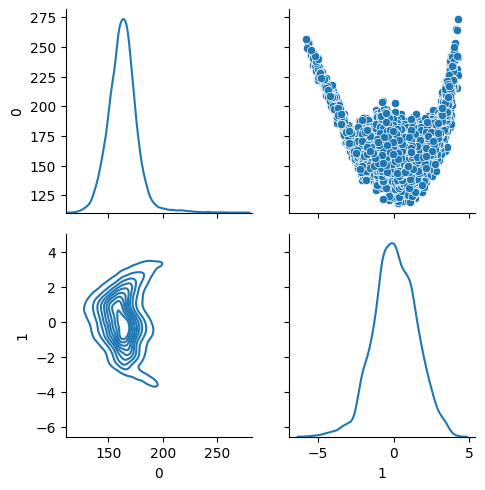

In [17]:
from elicit.plotting import func
path = "./elicit/results/deep_prior/toy_example_0"

import matplotlib.pyplot as plt
import seaborn as sns

#func.plot_loss(path)
prior = tf.reshape(pd.read_pickle(path+"/prior_samples.pkl"), (128*200,2))

g = sns.PairGrid(pd.DataFrame(prior), diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

In [ ]:
hyp = pd.read_pickle(path+"/final_results.pkl")["hyperparameter"]
hyp_val = tf.stack([hyp[k] for k in hyp], -1)
hyp_key = [k for k in list(hyp.keys())]

_, axs = plt.subplots(1,hyp_val.shape[-1], constrained_layout=True, figsize=(6,3),
                     sharex=True)
[axs[i].plot(hyp_val[:,i]) for i in range(hyp_val.shape[-1])]
[axs[i].set_title(hyp_key[i]) for i in range(hyp_val.shape[-1])]
[axs[i].set_xlabel("epochs") for i in range(hyp_val.shape[-1])]
plt.show()

### Elicited statistics 

In [8]:
model_data = pd.DataFrame(
    tf.round(tf.reduce_mean(pd.read_pickle(path+"/elicited_statistics.pkl")["quantiles_ypred"],0)[None,:]),
    columns=[fr"$Q_{{{i}}}$" for i in [5,25,50,75,95]], 
    index=["model"])

pd.concat([expert_data, model_data])

,$Q_{5}$,$Q_{25}$,$Q_{50}$,$Q_{75}$,$Q_{95}$
true,154.0,166.0,170.0,174.0,186.0
model,153.0,166.0,170.0,174.0,186.0


### Prior distributions

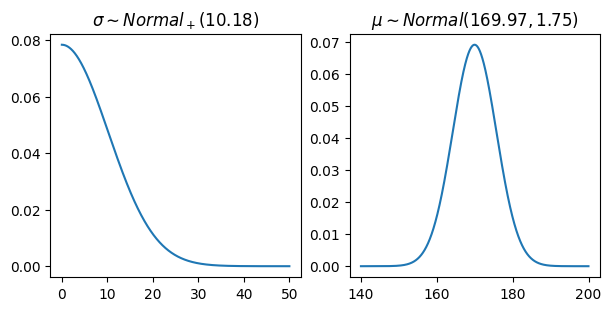

In [9]:
import matplotlib.pyplot as plt

hyp=pd.read_pickle(path+"/final_results.pkl")["hyperparameter"]
learned_hyp=tf.reduce_mean(tf.stack([hyp[k][-30:] for k in hyp],-1), 0)
gd = pd.read_pickle(path+"/global_dict.pkl")

xrge = tf.range(0.,50., 0.01)
xrge2 = tf.range(140.,200., 0.01)
sigma = gd["model_parameters"]["sigma"]["family"](learned_hyp[2]).prob(xrge)
mu = gd["model_parameters"]["mu"]["family"](learned_hyp[1], tf.exp(learned_hyp[0])).prob(xrge2)

_, axs = plt.subplots(1,2, constrained_layout=True, figsize=(6,3))
axs[0].plot(xrge, sigma)
axs[0].set_title(rf"$\sigma \sim Normal_+({learned_hyp[2]:.2f})$")
axs[1].plot(xrge2, mu)
axs[1].set_title(rf"$\mu \sim Normal({learned_hyp[1]:.2f}, {tf.exp(learned_hyp[0]):.2f})$")
plt.show()